# **Memasukkan library yang Dibutuhkan**

Kode berikut merupakan pendefinisian library yang akan digunakan untuk klasifikasi pada usus besar untuk mendeteksi penyakit polip, dan kolitis ulseratif.  library "`os, cv2`" digunakan untuk mengelolah file pada gambar, "`matplotlib.pyplot, seaborn`" digunakan untuk visualisai, "`numpy, pandas`" digunakan untuk komputasi numerik, "`graycomatrix, graycoprops`" digunakan untuk ekstraksi fitur yang terdapat pada gambar, dan library lainnya yang digunakan untuk machine learning.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# **Memuat dataset**

kode ini bertujuan untuk mengakses gambar dataset pada direktori folder tertentu, dimana kode berikut akan melakukan inisialisasi variabel penyimpanan dengan membuat `data` untuk menyimpan data gambar yang sudah diproses, `labels` untuk menyimpan label kategori setiap gambar, dan `file_name` menyimpan nama file asli. Lalu akan dilakukan looping melalui direktori dataset dengan membaca semua item dalam folder `dataset/`, dengan tiap sub-folder mewakili label pada satu kelas. Setiap sub-folder akan dilakukan looping untuk membaca setiap gambar yang terdapat dalam gambar lalu akan di baca dengan `cv2.imread`. hasil dari pembacaan tiap gambar akan dilakukan grayscaling dengan `cv2.cvtColor`, dan di resize dengan `cv2.resize` untuk menyeragamkan tiap isi gambar agar tetap konsisten. hasil dari preprocessing tersebut lalu disimpan pada inisialisasi variabel sebelumnya, lalu di koversi menjadi array dengan `np.array` untuk untuk kompatibilitas dengan library machine learning.

In [2]:
data = []
labels = []
file_name = []

# Loop melalui setiap subfolder (normal-cecum, polyps, ulcerative-colitis)
for sub_folder in os.listdir("dataset/"):
    sub_folder_path = os.path.join("dataset/", sub_folder)
    
    # Loop melalui setiap file gambar di subfolder
    for filename in os.listdir(sub_folder_path):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv2.imread(img_path) # Baca gambar
        if img is None:  # Skip jika gambar corrupt
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (512, 512)) #Resize gambar ke ukuran tetap agar bisa di-convert ke numpy array

        # Simpan ke list
        data.append(img_resized)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

        
data = np.array(data)
labels = np.array(labels)

# **Menyiapkan preprocessing**

kode dibawah ini bertujuan untuk pendeklarasian preprocessing yang akan digunakan pada percobaan pertama, yang berisi preprocessing `median` yang penting dalam pengolahan citra medis yang berfungsi mem filtering noise salt and papper,dan mempertahankan edges untuk mendeteksi penyakit polip serta menyederhanakan tekstur tanpa merusak struktur penting. `filteringCItra` digunakan untuk melakukan operasi filtering yaitu `median` yang akan kita gunakan. `convo` digunakan untuk operasi konvolusi dengan kernel `sharpen_kernel` untuk mempertajam tepian polip yang kabur, meningkatkan visibilitas pada kasus kolitis, dan membantu ekstraksi fitur tekstur yang lebih jelas. lalu `thresholding` untuk mengubah citra menjadi biner sehingga memisahkkan daerah polip dan jaringan normal. 

In [3]:
def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])
    
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result


sharpen_kernel = np.array([  [-1, -1, -1],
                             [-1,  9, -1],
                             [-1, -1, -1]])

def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

# **Percobaan 1**

pada percobaan pertama ini menggunakan 3 preprocessing yaitu `median` menggunakan kernel size berukuran 3, `sharpening`, dan `tresholding` dengan nilai tresholdnya 120.

In [4]:
def preprocess_1(img):
    img_median = filteringCitra(img, kernel_size=3, filter="median") 
    img_sharp = convo(img_median, sharpen_kernel)
    img_tresh = thresholding(img_sharp, 120, 255, 0)
    return img_tresh

# **Visualisasi data hasil percobaan 1**

kode ini bertujuan memvisualisasikan hasil dari preprocessing dengan memproses data gambar pada `data` menggunakan `preprocess_1`, hasilnya akan disimpan pada `dataPreprocessed1`, lalu menyiapkan label dan mengurutkannya lalu melakukan visualisasi per kategori dengan mengumpulkan indeks semua gambar yang termasuk dalam kategori, lalu menyiapkan grid untuk tampilan gambar, lalu menampilkan gambar dengan layout yang telah disempurnakan agar tidak overlap.

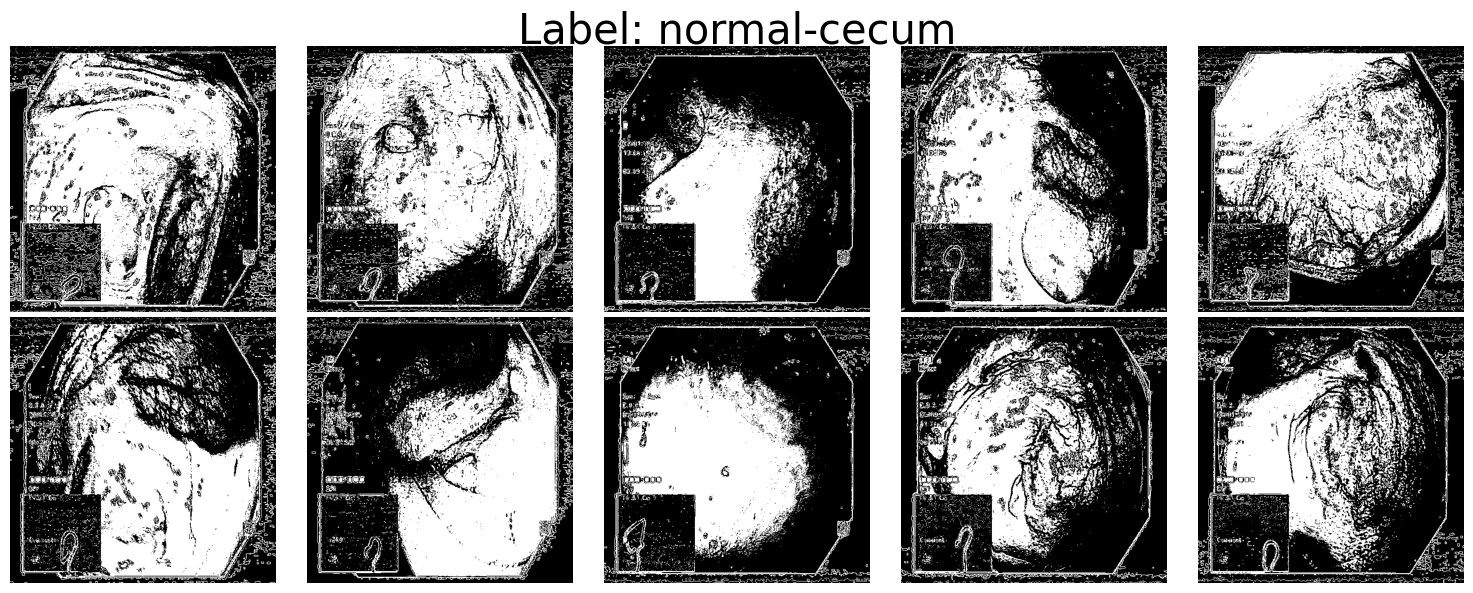

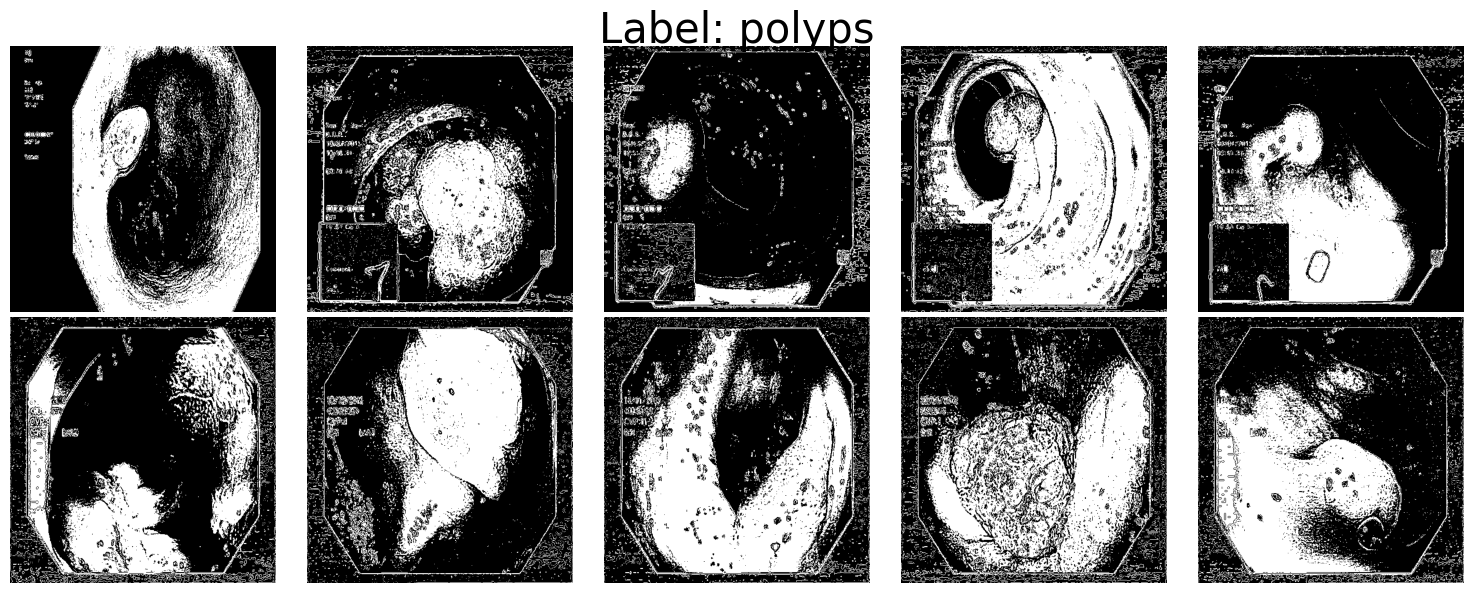

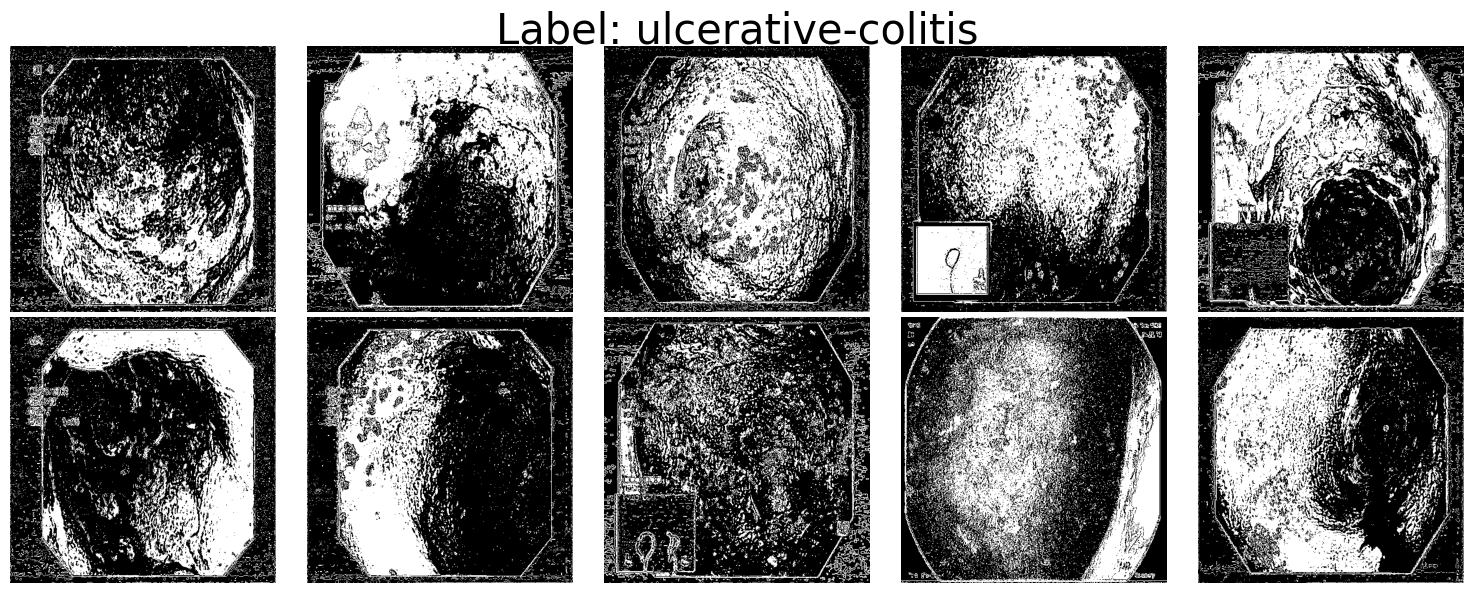

In [5]:
dataPreprocessed1 = [preprocess_1(img) for img in data] 
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 10x10 (cukup untuk 100 gambar, 10*10 = 100)
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Label: {label}', fontsize=30)
    
    for k in range(min(10, len(idxs))):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed1[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# **Ekstraksi fitur**

fungsi yang digunakan untuk ekstraksi fitur berikut adalah `glcm` yang digunakan untuk menghitung gray-level co-occurrence matrix, yaitu dengan mengkonversi sudut menjadi radian agar bisa digunakan dalam `glcm`. fungsi ini menggunakan `graycomatrix()` untuk mengembalikan matrix dari gambar.

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

# **Macam-macam fitur dari GLCM**

kode dibawah merupakan pendeklarasian berbagaimacam fitur ekstraksi dari GLCM, yaitu `correlation` untuk mengukur hubungan linear yang berdekatan antara intensitas piksel, `dissimilarity` mengukur variasi lokal dalam tekstur, nilai tertinggi menunjukan ketidakateraturan, `homogenity` mengukur kedekatan distribusi GLCM dengan diagonal, nilai tertinggi menunjukan tekstur homogen, `contrast` mengukur nilai variasi intesitas lokal, `ASM` mengukur keseragaman tekstur, `energy` mengukur keteraturan tekstur, dan `entropyGlcm` mengukur ketidakpastian tekstur. lalu fungsi fungsi tersebut akan dilakukan proses ekstraksi untuk setiap sudut.

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed1)):
    D0 = glcm(dataPreprocessed1[i], 0)
    D45 = glcm(dataPreprocessed1[i], 45)
    D90 = glcm(dataPreprocessed1[i], 90)
    D135 = glcm(dataPreprocessed1[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

# **Inisialisasi variabel untuk menyimpan fitur GLCM**

kode dibawah ini mendeklarasikan variabel yang akan digunakan untuk menyimpan hasil ekstraksi dari berbagai sudut dan macam macam fitur GLCM yang telah didefinisikan sebelumnya. 

In [8]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

# **Ekstraksi Correlation**

kode dibawah ini melakukan ekstraksi fitur `correlation` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [9]:
for i in range(len(dataPreprocessed1)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

# **Ekstraksi Contrast**

kode dibawah ini melakukan ekstraksi fitur `contrast` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [10]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

# **Ekstraksi Dissimilarity**

kode dibawah ini melakukan ekstraksi fitur `dissimilarity` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [11]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

# **Ekstraksi Homogenity**

kode dibawah ini melakukan ekstraksi fitur `homogenity` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [12]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

# **Ekstraksi Entropy GLCM**

kode dibawah ini melakukan ekstraksi fitur `entropyGlcm` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [13]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

# **Ekstraksi ASM (Angular Second Moment)**

kode dibawah ini melakukan ekstraksi fitur `ASM` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [14]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

# **Ekstraksi Energy**

kode dibawah ini melakukan ekstraksi fitur `energy` dari matriks GLCM pada 4 sudut 0°, 45°, 90°, dan 135°, yang akan disimpan pada variabel sebelumnya.

In [15]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

# **Hasil Ekstraksi fitur**

kode berikut menampilkan hasil dari ekstraksi fitur dengan membuatnya dalam struktur tabel, lalu mengkonversi ke `dataframe` untuk  mengubah dictionary menjadi tabel struktur DataFrame pandas, lalu menjadi file CSV.



In [16]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

Filename               Label  \
0             00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg        normal-cecum   
1             01c49663-9674-44ae-b61e-05243a30e4ab.jpg        normal-cecum   
2             01e023db-5c76-4c28-91ab-06e36cd31495.jpg        normal-cecum   
3             02dcedf1-c0bd-4ef4-b072-ea8f11da6a1d.jpg        normal-cecum   
4             032a3076-c75c-4089-a57c-1b19e5f6589e.jpg        normal-cecum   
..                                                 ...                 ...   
295  fc79c489-b358-4368-b965-330615af73d4_00000332.jpg  ulcerative-colitis   
296  fc79c489-b358-4368-b965-330615af73d4_00000351.jpg  ulcerative-colitis   
297  fc79c489-b358-4368-b965-330615af73d4_00000403.jpg  ulcerative-colitis   
298  fc79c489-b358-4368-b965-330615af73d4_00000411.jpg  ulcerative-colitis   
299  fc79c489-b358-4368-b965-330615af73d4_00000413.jpg  ulcerative-colitis   

        Contrast0    Contrast45    Contrast90   Contrast135  Homogeneity0  \
0     9776.665030  13020.140567  10651.263607  12783.569207      0.849650   
1     9589.517337  12410.284504  10105.975378  12293.741982      0.852528   
2     6003.141244   7805.609756   6240.493231   7623.823342      0.907681   
3     8367.216740  10440.018612   8265.316934  10549.588505      0.871325   
4    10265.038489  13074.178446  10407.201145  12962.118328      0.842139   
..            ...           ...           ...           ...           ...   
295  10582.170568  11865.423310   8470.110690  11904.768862      0.837262   
296  12959.667013  14726.193604   9952.877133  14214.950444      0.800700   
297  10447.712531  11546.425508   7635.029354  11424.404491      0.839330   
298   9525.395020  11122.838263   7763.025452  11193.560648      0.853514   
299   8671.424940  10095.122472   7097.694281  10050.796470      0.866647   

     Homogeneity45  Homogeneity90  Homogeneity135  ...     ASM90    ASM135  \
0         0.799770       0.836200        0.803408  ...  0.363038  0.342072   
1         0.809149       0.844586        0.810941  ...  0.373026  0.351113   
2         0.879962       0.904031        0.882757  ...  0.494745  0.477605   
3         0.839449       0.872892        0.837764  ...  0.399921  0.374767   
4         0.798939       0.839953        0.800663  ...  0.365567  0.340397   
..             ...            ...             ...  ...       ...       ...   
295       0.817528       0.869743        0.816923  ...  0.540340  0.503731   
296       0.773534       0.846940        0.781396  ...  0.448652  0.407123   
297       0.822434       0.882585        0.824310  ...  0.491722  0.450099   
298       0.828948       0.880617        0.827860  ...  0.450475  0.412751   
299       0.844753       0.890848        0.845434  ...  0.473022  0.439228   

      Energy0  Energy45  Energy90  Energy135  Correlation0  Correlation45  \
0    0.610133  0.582990  0.602526   0.584869      0.699290       0.599521   
1    0.615245  0.591609  0.610759   0.592548      0.702521       0.614880   
2    0.705437  0.689545  0.703381   0.691090      0.779433       0.713438   
3    0.631474  0.613113  0.632393   0.612182      0.736922       0.671881   
4    0.605853  0.582550  0.604621   0.583436      0.684274       0.597871   
..        ...       ...       ...        ...           ...            ...   
295  0.719285  0.710010  0.735078   0.709740      0.530159       0.473692   
296  0.647110  0.634635  0.669815   0.638062      0.527347       0.463414   
297  0.678550  0.669989  0.701229   0.670894      0.602997       0.561641   
298  0.656206  0.643013  0.671174   0.642457      0.670342       0.615382   
299  0.674326  0.662388  0.687766   0.662743      0.689665       0.639034   

     Correlation90  Correlation135  
0         0.672389        0.606797  
1         0.686477        0.618496  
2         0.770676        0.720111  
3         0.740128        0.668437  
4         0.679902        0.601318  
..             ...             ...  
295       0.623929        0.471947  
296       0.637047        

# **Menghitung Korelasi**

kode dibawah ini Menghitung matriks korelasi Pearson antar semua fitur, lalu menseleksi fitur berdasarkan korelasi tinggi dengan `threshold` jika korelasi lebih tinggi dari `threshold` maka fitur akan disaring, hasil yang disaring akan disimpan pada dataset baru, lalu akan divisualisasikan dengan `heatmap`.

<Axes: >

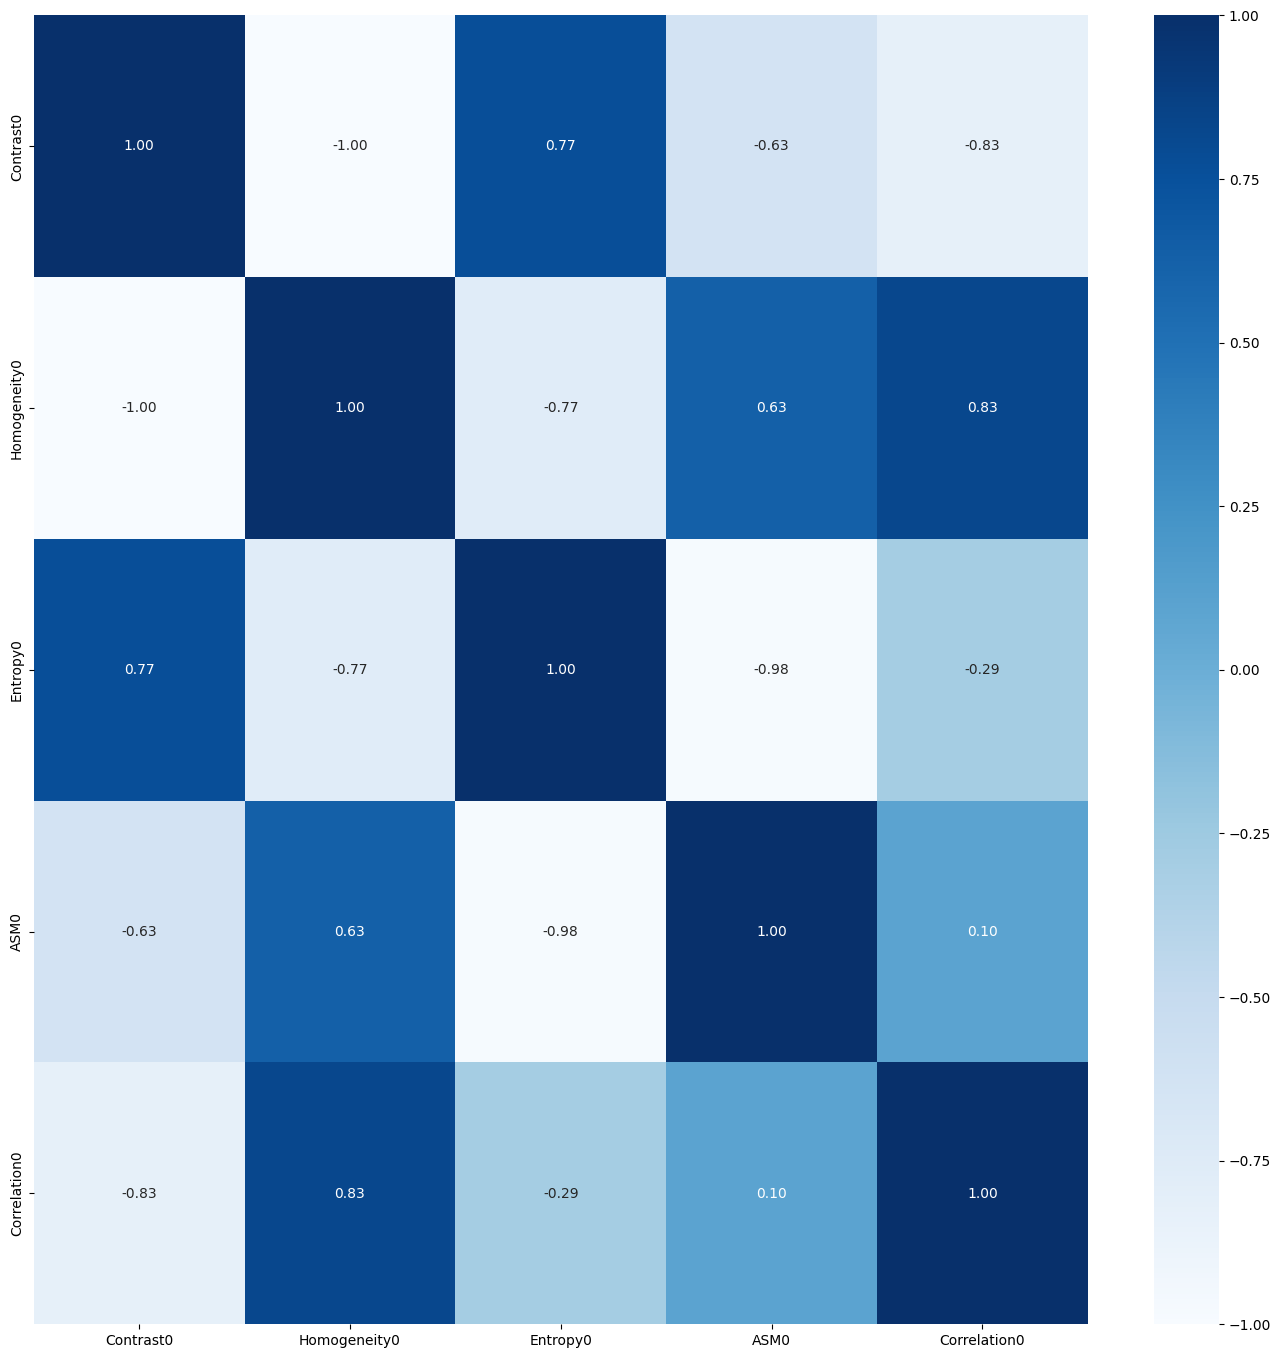

In [17]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# **Mengatur proporsi pembagaian data training dan testing**

kode ini memanggil fungsi `train_test_split` untuk membagi dataset menjadi training dan testing, dengan `test_size` 0.2 untuk 20% data untuk testing lalu menampilkan data train sebanyak 240 data, dan 60 data untuk testing, dengan masing-masing data mempunyai 11 fitur.

In [18]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 5)
(60, 5)


# **Normalisasi data**

kode ini melakukan normalisasi pada data testing `X_test`, dan data training `X_train`

In [19]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# **Evaluasi performa model**

kode dibawah ini digunakan untuk mengevaluasi perform model dengan mencetak `precission`, `recall`, `f-1 score`, dan `support` untuk masing masing kelas, lalu akan menunjukan matriks dengan prediski benar pada digonal utama, dan prediksi salah pada diagonal samping, hasil akurasi benar nya akan ditampilkan. 

**inisialisasi model klasifikasi** 

dibawah evaluasi performa terdapat tiga model machine learning diinisialisasi dengan konfigurasi tertentu, `RandomForestClassifier` yaitu random forest dengan algoritma kumpulan decision tree, dapat mengatur jumalah decision tree pada `n_estimators`, dan `random_state` untuk reproduktibilitas hasil, `SVC` menggunakan algoritma support vector machine, dengan menggunakan kernel `rbf` untuk non-linear decision boundary, dan `KNeighborsClassifier` menggunakan algoritma k-Nearest Neighbors, dengan `n_neighbors` merupakan jumlah tetangga untuk voting

In [20]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# **Hasil Evaluasi Random Forest**

kode dibawah ini melatih model random forest dengan data training, lalu menampilkan hasil prediksi dan evaluasi dari training, dan testing set

In [21]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.92      0.99      0.95        78
            polyps       0.94      0.90      0.92        84
ulcerative-colitis       0.96      0.92      0.94        78

          accuracy                           0.94       240
         macro avg       0.94      0.94      0.94       240
      weighted avg       0.94      0.94      0.94       240

[[77  1  0]
 [ 5 76  3]
 [ 2  4 72]]
Accuracy: 0.9375

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.50      0.45      0.48        22
            polyps       0.39      0.56      0.46        16
ulcerative-colitis       0.76      0.59      0.67        22

          accuracy                           0.53        60
         macro avg       0.55      0.54      0.53        60
      weighted avg       0.57      0.53      0.54        60

[[10  8  4]
 [ 7  9  0]
 [ 3  6 13]]
Accuracy: 0.5

# **Hasil Evaluasi Support Vector machine (SVM)**

kode dibawah ini melatih model support vector machine dengan data training, lalu menampilkan hasil prediksi dan evaluasi dari training, dan testing set

In [22]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.61      0.65      0.63        78
            polyps       0.59      0.67      0.63        84
ulcerative-colitis       0.77      0.60      0.68        78

          accuracy                           0.64       240
         macro avg       0.66      0.64      0.64       240
      weighted avg       0.65      0.64      0.64       240

[[51 21  6]
 [20 56  8]
 [13 18 47]]
Accuracy: 0.6416666666666667

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.57      0.59      0.58        22
            polyps       0.42      0.69      0.52        16
ulcerative-colitis       0.82      0.41      0.55        22

          accuracy                           0.55        60
         macro avg       0.60      0.56      0.55        60
      weighted avg       0.62      0.55      0.55        60

[[13  7  2]
 [ 5 11  0]
 [ 5  8  9]]


# **Hasil Evaluasi k-Nearest Neighbors(KNN)**

kode dibawah ini melatih model k-nearest neighbors dengan data training, lalu menampilkan hasil prediksi dan evaluasi dari training, dan testing set

In [23]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.64      0.71      0.67        78
            polyps       0.62      0.71      0.66        84
ulcerative-colitis       0.81      0.59      0.68        78

          accuracy                           0.67       240
         macro avg       0.69      0.67      0.67       240
      weighted avg       0.69      0.67      0.67       240

[[55 19  4]
 [17 60  7]
 [14 18 46]]
Accuracy: 0.6708333333333333

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.54      0.68      0.60        22
            polyps       0.37      0.44      0.40        16
ulcerative-colitis       0.92      0.55      0.69        22

          accuracy                           0.57        60
         macro avg       0.61      0.55      0.56        60
      weighted avg       0.63      0.57      0.58        60

[[15  6  1]
 [ 9  7  0]
 [ 4  6 12]]


# **Menampilkan Matriks confusion**

kode ini bertujuan untuk mengevaluasi performa model dengan menvisualisasikan dalam bentuk matriks, dimana prediksi yang benar merupakan diagonal matriks, dan prediksi yang salah berada diluar diagonal, confusion matriks ini digunakan melihat akurasi per kelas, mengedintifikasi masalah klasifikasi, serta membandingkan model machine learning tersebut.

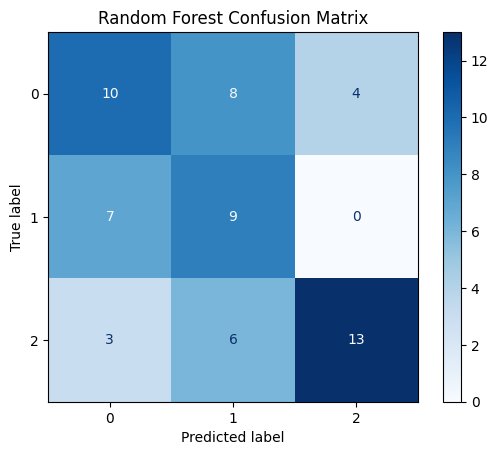

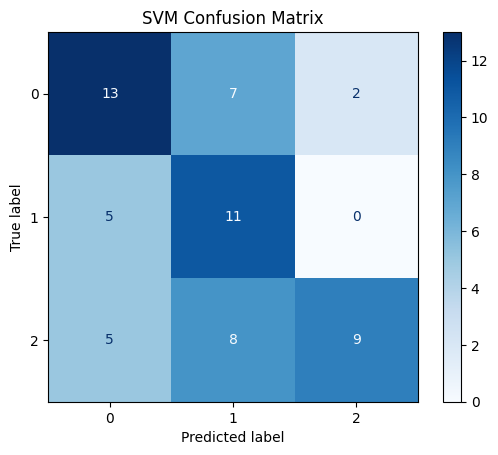

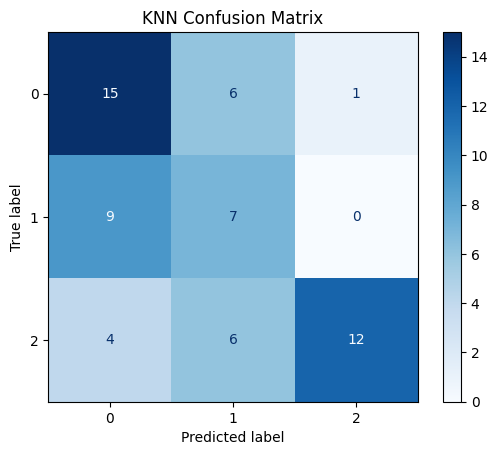

In [24]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")